Harsh Karia <br>
GitHub Username: harshkaria <br>
USC ID: 5860082592

References: <br>
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html <br>
https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook <br>
https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

In [48]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install scikit-multilearn

     |████████████████████████████████| 89 kB 1.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install xgboost

     |████████████████████████████████| 1.7 MB 1.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [328]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import preprocessing
import graphviz
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import math
import functools
from IPython.display import IFrame, HTML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error



In [99]:
# reading csv files
diag_cols = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing', 'Micturition pains', 'Burning of urethra', 'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
data_diag = pd.read_csv("../data/diagnosis.data", sep = '\s+', encoding = 'utf-16', header=None)
data_diag.columns = [diag_cols]


temperature = []
for index, row in data_diag['Temperature of patient'].iterrows():
    temperature.append(float(row[0].replace(',', '.')))
data_diag['Temperature of patient'] = temperature

print(data_diag)


    Temperature of patient Occurrence of nausea Lumbar pain Urine pushing  \
0                     35.5                   no         yes            no   
1                     35.9                   no          no           yes   
2                     35.9                   no         yes            no   
3                     36.0                   no          no           yes   
4                     36.0                   no         yes            no   
..                     ...                  ...         ...           ...   
115                   41.4                   no         yes           yes   
116                   41.5                   no          no            no   
117                   41.5                  yes         yes            no   
118                   41.5                   no         yes           yes   
119                   41.5                   no         yes           yes   

    Micturition pains Burning of urethra Inflammation of urinary bladder  \

In [362]:
X = data_diag.drop(data_diag.columns[-2:], axis=1)
# Response Variables
Y = data_diag.drop(data_diag.columns[:-2], axis=1)

labelEncodersX = []
for x in X.columns[1:]:
    labelEncodersX.append(preprocessing.LabelEncoder())
    labelEncodersX[-1].fit(X[x].values.ravel())
    X[x] = labelEncodersX[-1].transform(X[x])
    
labelEncodersY = []
for y in Y.columns:
    labelEncodersY.append(preprocessing.LabelEncoder())
    labelEncodersY[-1].fit(Y[y].values.ravel())
    Y[y] = labelEncodersY[-1].transform(Y[y])


### 1b - Building Basic Decision Tree

In [101]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt_labelled = LabelPowerset(classifier = dt)
dt.fit(X, dt_labelled.transform(Y))

DecisionTreeClassifier(criterion='entropy')

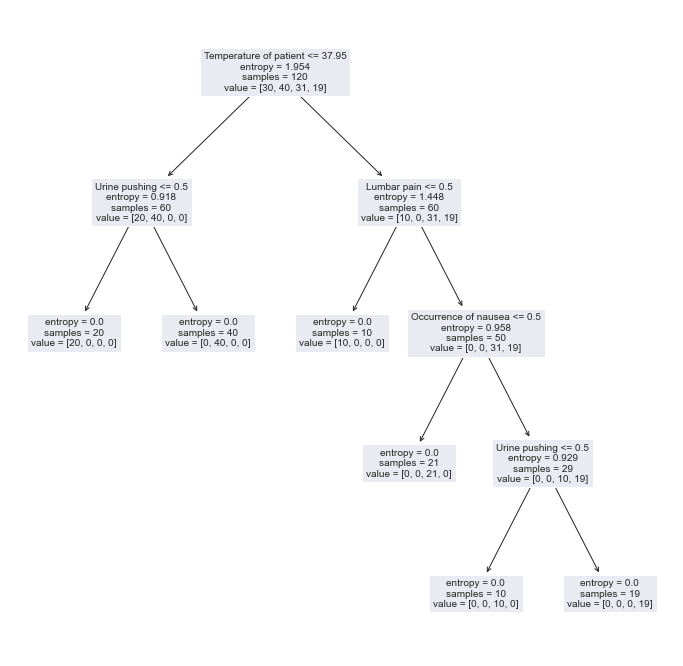

In [102]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(dt, fontsize=10, feature_names=diag_cols[:-2])
plt.show()

### 1c - Tree to If-Then Rules

In [103]:
def tree_to_pseudo(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    def recurse(left, right, threshold, features, node, depth=0):
        indent = "\t" * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) then :")
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth+1)
                print(indent,"else :")
                if right[node] != -1:
                    recurse(left, right, threshold, features, right[node], depth+1)
        else:
            print(indent,"return " + str(value[node][0]))
        
    recurse(left, right, threshold, features, 0)

In [104]:
tree_to_pseudo(dt, diag_cols)

 if ( Temperature of patient <= 37.95000076293945 ) then :
	 if ( Urine pushing <= 0.5 ) then :
		 return [20.  0.  0.  0.]
	 else :
		 return [ 0. 40.  0.  0.]
 else :
	 if ( Lumbar pain <= 0.5 ) then :
		 return [10.  0.  0.  0.]
	 else :
		 if ( Occurrence of nausea <= 0.5 ) then :
			 return [ 0.  0. 21.  0.]
		 else :
			 if ( Urine pushing <= 0.5 ) then :
				 return [ 0.  0. 10.  0.]
			 else :
				 return [ 0.  0.  0. 19.]


### 1d - Cost Complexity Pruning

In [115]:
train, test = train_test_split(data_diag, test_size=0.2)

In [116]:
# Predictors and responses
train_X = train.drop(train.columns[-2:], axis=1)
train_Y = train.drop(train.columns[:-2], axis=1)
test_X = test.drop(test.columns[-2:], axis=1)
test_Y = test.drop(test.columns[:-2], axis=1)


In [117]:
for col in train_X.columns[1:]:
    train_X[col] = train_X[col].map({'yes': 1, 'no': 0})

for col in train_Y.columns:
    train_Y[col] = train_Y[col].map({'yes': 1, 'no': 0})

for col in test_X.columns[1:]:
    test_X[col] = test_X[col].map({'yes': 1, 'no': 0})

for col in test_Y.columns:
    test_Y[col] = test_Y[col].map({'yes': 1, 'no': 0})


In [118]:
path = dt.cost_complexity_pruning_path(train_X,train_Y)
alphas = path['ccp_alphas']

In [119]:
accuracy_train, accuracy_test = [], []

cv = RepeatedKFold(n_splits=5, n_repeats=3,  random_state=1)

best_alpha = 0
best_test_score = 0

for x in alphas:
    dt = tree.DecisionTreeClassifier(ccp_alpha = x)
    dt_labelled = LabelPowerset(classifier = dt)
    dt.fit(train_X, dt_labelled.transform(train_Y))
    y_train_pred = dt.predict(train_X)
    y_test_pred = dt.predict(test_X)
    scores = cross_val_score(dt, train_X, dt_labelled.transform(train_Y), scoring='accuracy', cv=cv, n_jobs=-1)
    accuracy_train.append(np.mean(scores))
    accuracy_test.append(accuracy_score(dt_labelled.transform(test_Y), y_test_pred))
    if (accuracy_test[-1]>best_test_score):
        best_alpha = x
        best_test_score = accuracy_test[-1]

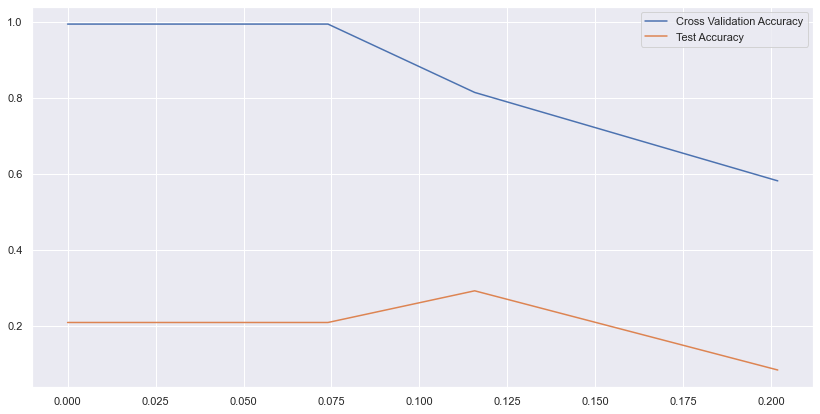

In [120]:
sns.set()

plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train, x=alphas, label="Cross Validation Accuracy")
sns.lineplot(y=accuracy_test, x=alphas, label="Test Accuracy")
plt.show()

In [121]:
print(best_alpha)

0.11569148936170214


In [361]:
X = data_diag.drop(data_diag.columns[-2:], axis=1)
# Response Variables
Y = data_diag.drop(data_diag.columns[:-2], axis=1)


X = data_diag.drop(data_diag.columns[-2:], axis=1)
# Response Variables
Y = data_diag.drop(data_diag.columns[:-2], axis=1)

labelEncodersX = []
for x in X.columns[1:]:
    labelEncodersX.append(preprocessing.LabelEncoder())
    labelEncodersX[-1].fit(X[x].values.ravel())
    X[x] = labelEncodersX[-1].transform(X[x])
    
labelEncodersY = []
for y in Y.columns:
    labelEncodersY.append(preprocessing.LabelEncoder())
    labelEncodersY[-1].fit(Y[y].values.ravel())
    Y[y] = labelEncodersY[-1].transform(Y[y])



In [123]:
dt = tree.DecisionTreeClassifier(ccp_alpha = best_alpha)
dt_labelled = LabelPowerset(classifier = dt)
dt.fit(X, dt_labelled.transform(Y))

DecisionTreeClassifier(ccp_alpha=0.11569148936170214)

### 1e - Best Decision Tree (pruned)

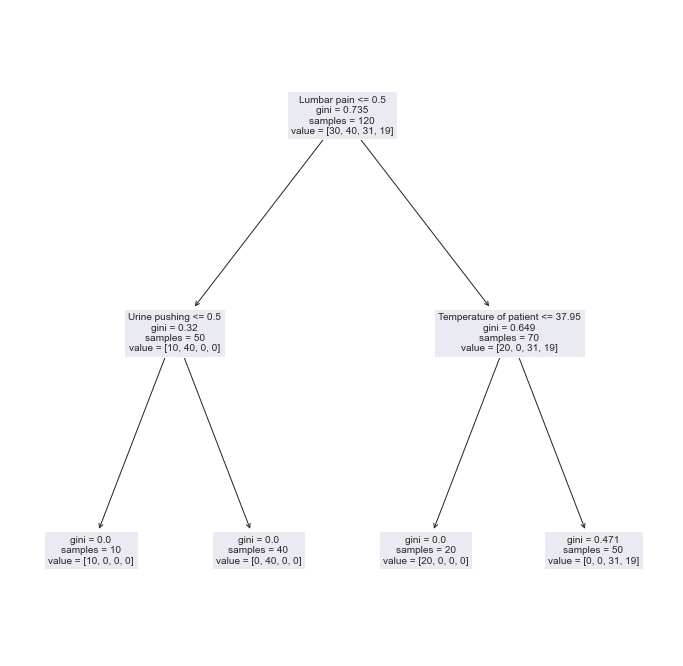

In [124]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(dt, fontsize=10, feature_names=diag_cols[:-2])
plt.show()

In [125]:
tree_to_pseudo(dt, diag_cols)

 if ( Lumbar pain <= 0.5 ) then :
	 if ( Urine pushing <= 0.5 ) then :
		 return [10.  0.  0.  0.]
	 else :
		 return [ 0. 40.  0.  0.]
 else :
	 if ( Temperature of patient <= 37.95000076293945 ) then :
		 return [20.  0.  0.  0.]
	 else :
		 return [ 0.  0. 31. 19.]


## 2. Lasso and Boosting

In [174]:
communities_data = pd.read_csv('../data/communities.data', sep=',', header=None)
column_file = open('../data/communities.arff', 'r')
communities_attr = column_file.readlines()

communities_attr = []
for line in attrs[1:-1]:
    if(len(line.lstrip()) > 0):
        communities_attr.append(line.split(" ")[1])
communities_data.columns = [communities_attr]

In [175]:
communities_data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


## 2b - Imputation

In [176]:
train_data = communities_data.head(1495)
test_data = communities_data.tail(1994-1495)

In [177]:
# Ignore non predictive features: state, community, communityname, county, fold
non_predictive_ftrs = ['state', 'community', 'communityname', 'county', 'fold']
train_data = train_data.drop(non_predictive_ftrs, axis=1)
test_data = test_data.drop(non_predictive_ftrs, axis=1)

for col in train_data.columns:
    train_data.loc[train_data[col] == '?', col] = -1
    test_data.loc[test_data[col] == '?', col] = -1

In [178]:
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(train_data)

SimpleImputer(missing_values=-1)

In [179]:
train_data = pd.DataFrame(data=imp.transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(data=imp.transform(test_data), columns=train_data.columns)

print(train_data)
print(test_data)

     population householdsize racepctblack racePctWhite racePctAsian  \
0          0.19          0.33         0.02         0.90         0.12   
1          0.00          0.16         0.12         0.74         0.45   
2          0.00          0.42         0.49         0.56         0.17   
3          0.04          0.77         1.00         0.08         0.12   
4          0.01          0.55         0.02         0.95         0.09   
...         ...           ...          ...          ...          ...   
1490       0.00          0.59         0.01         0.69         1.00   
1491       0.16          0.62         0.03         0.74         0.48   
1492       0.01          0.36         0.95         0.24         0.03   
1493       0.06          0.53         0.01         0.98         0.05   
1494       0.05          0.43         0.08         0.65         0.12   

     racePctHisp agePct12t21 agePct12t29 agePct16t24 agePct65up  ... LandArea  \
0           0.17        0.34        0.47        0.29  

### 2c - correlation matrix

In [263]:
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

### 2d - CV Matrix

In [264]:
def calculate_cv(df):
    coeffs = []
    for col in df.columns:
        coeffs.append(np.std(df[col])/np.mean(df[col]))
    return coeffs

In [265]:
coeffs = calculate_cv(train_data)
cols = []
for col in train_data.columns:
    cols.append(col)
summary_df_dict = {'Feature': cols,
              'Variance Coefficient': coeffs
             }

summary_df = pd.DataFrame(summary_df_dict)
summary_df.set_index('Feature')

,Variance Coefficient
Feature,
"(population,)",2.240355
"(householdsize,)",0.355681
"(racepctblack,)",1.428407
"(racePctWhite,)",0.330102
"(racePctAsian,)",1.358645
...,...
"(LemasPctPolicOnPatr,)",0.115700
"(LemasGangUnitDeploy,)",0.362868
"(LemasPctOfficDrugUn,)",2.552092


### 2e - Scatter Plots

In [344]:
scatters = []
for i in range(len(train_data.columns)):
    scatters.append({
        'column': train_data.columns[i],
        'coeff': coeffs[i]
    })

scatters.sort(key = lambda x: x['coeff'], reverse=True)


In [267]:
# Get a list of the columns of the highest sqrt(128) features
ftrs = []
for ftr_i in range(0, math.floor(math.sqrt(128))):
    ftr = scatters[ftr_i]
    ftrs.append(ftr['column'])

    

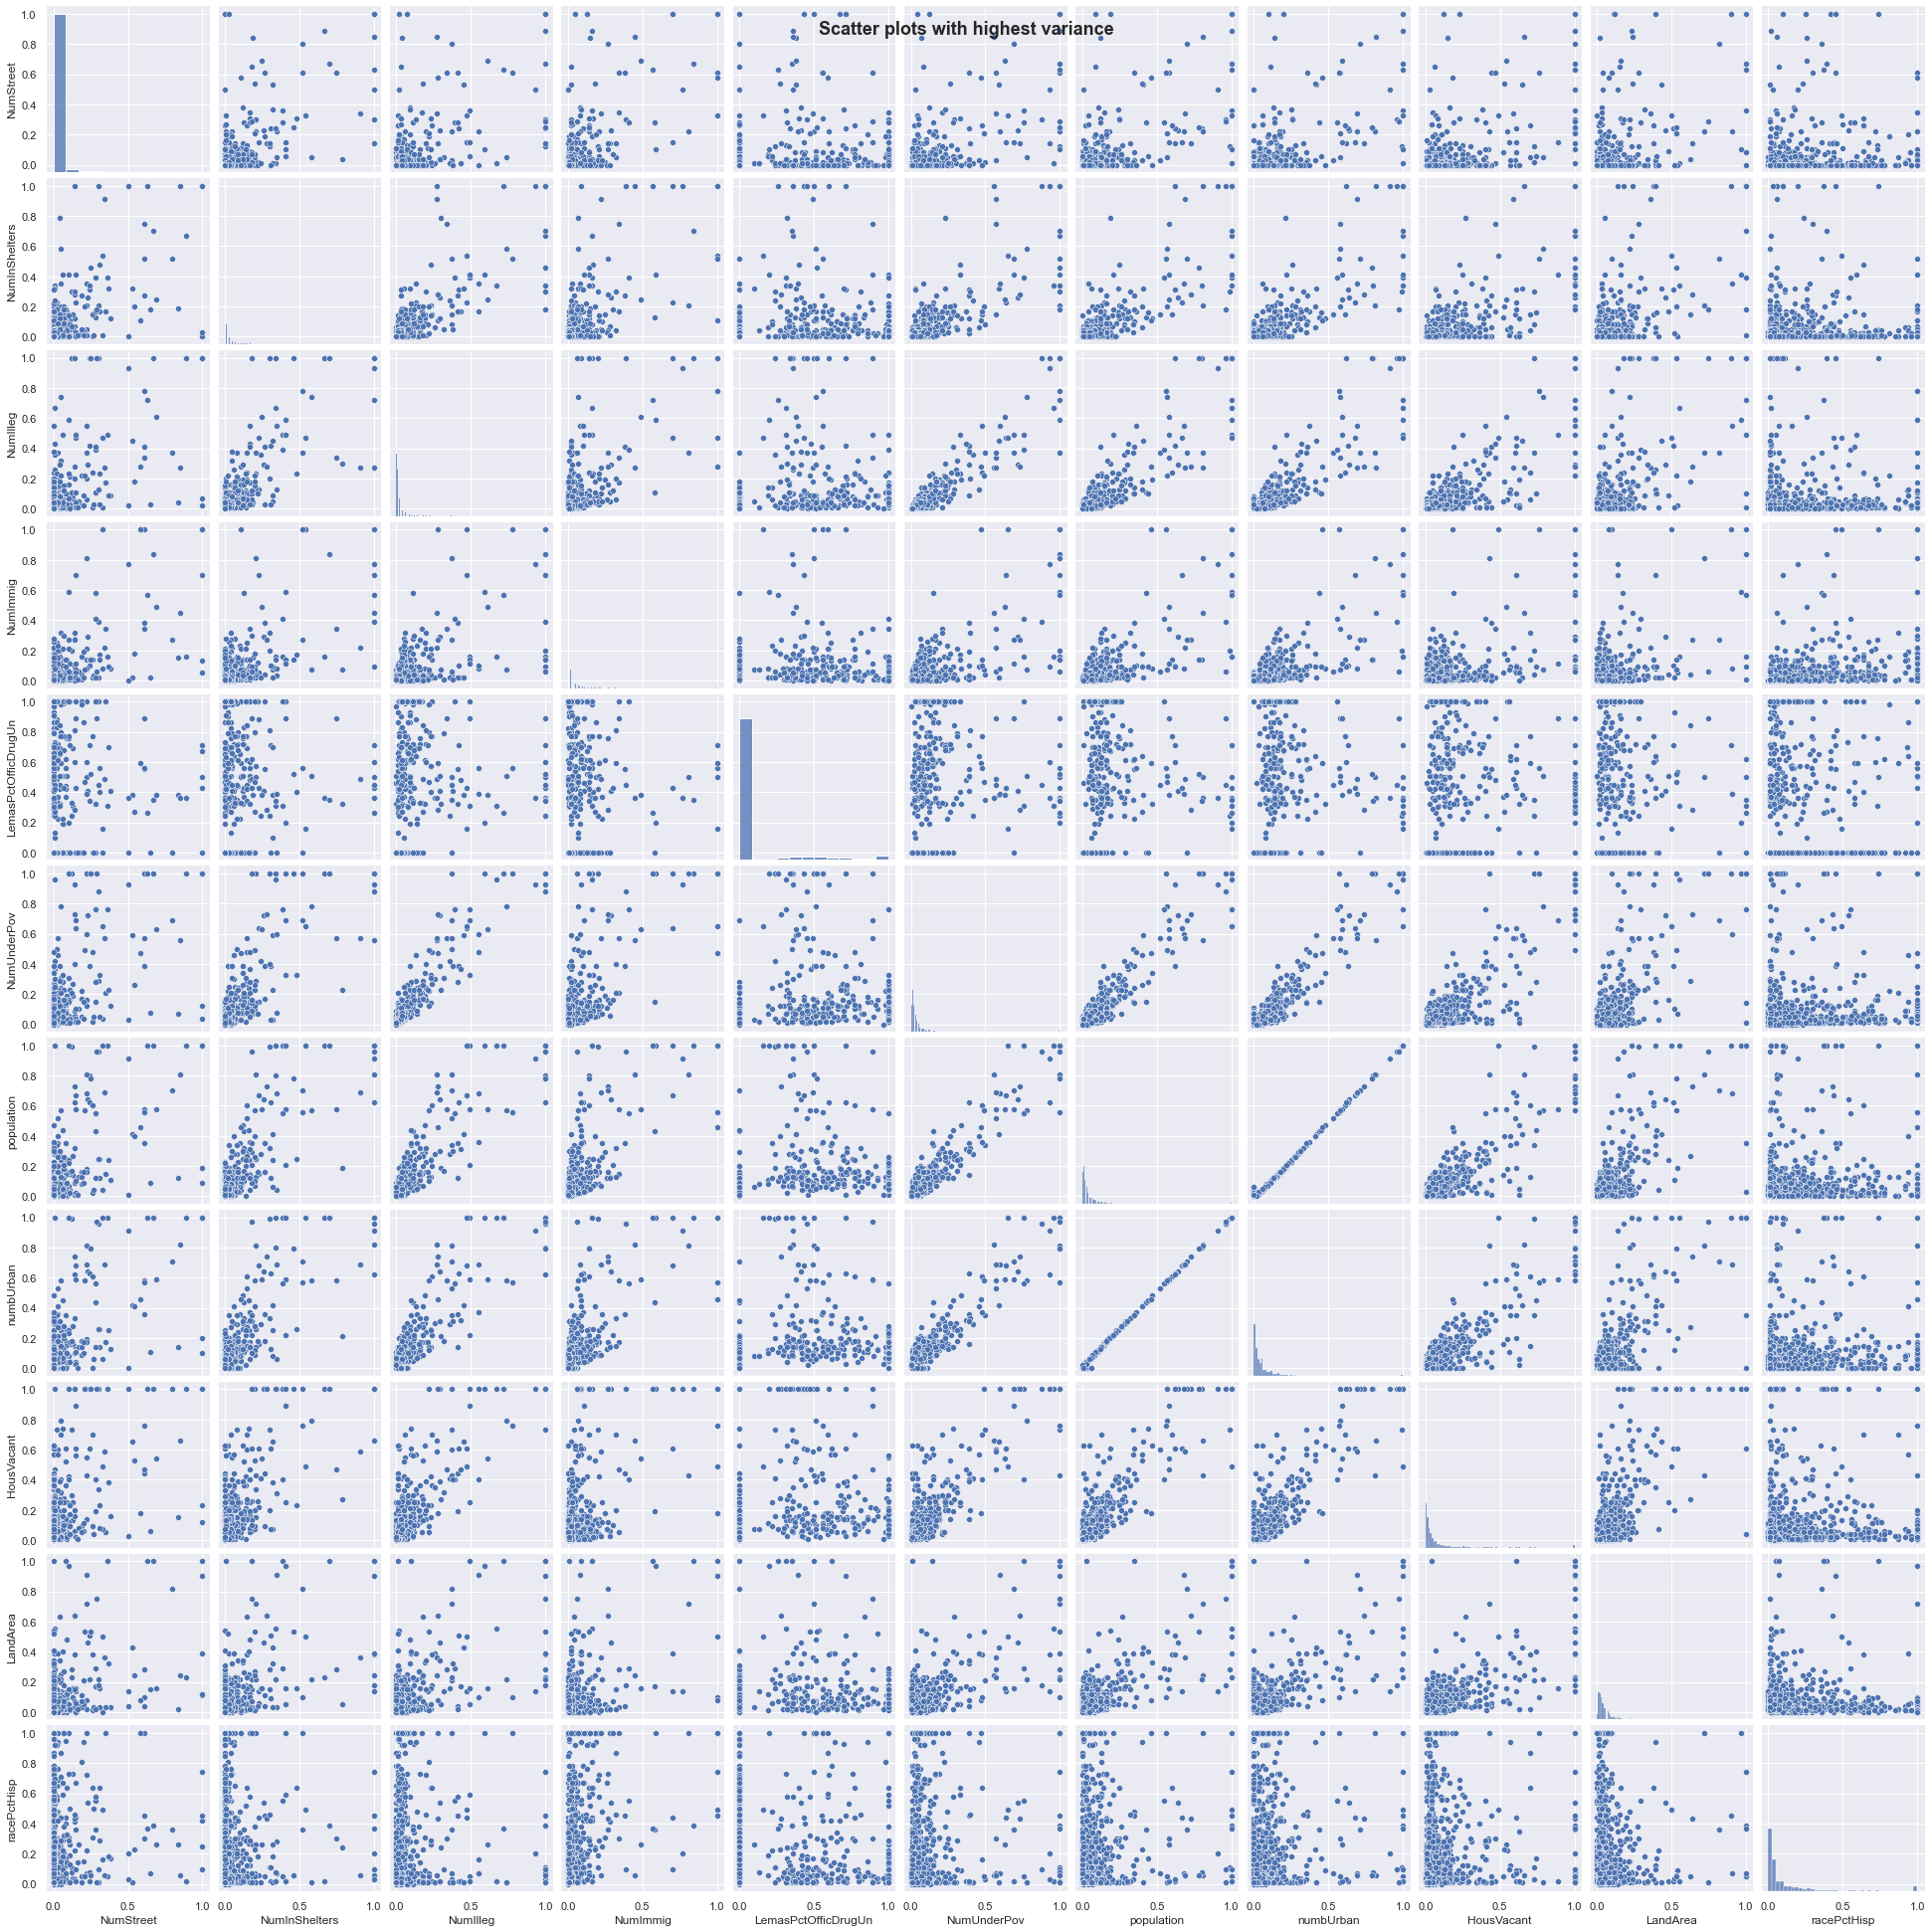

In [268]:
df_best_ftrs = train_data[ftrs]
df_best_ftrs.columns = df_best_ftrs.columns.get_level_values(0)
plt_ftrs = sns.pairplot(df_best_ftrs, vars = df_best_ftrs.columns)
plt_ftrs.fig.suptitle("Scatter plots with highest variance", fontsize=18, weight='bold')
plt.show()


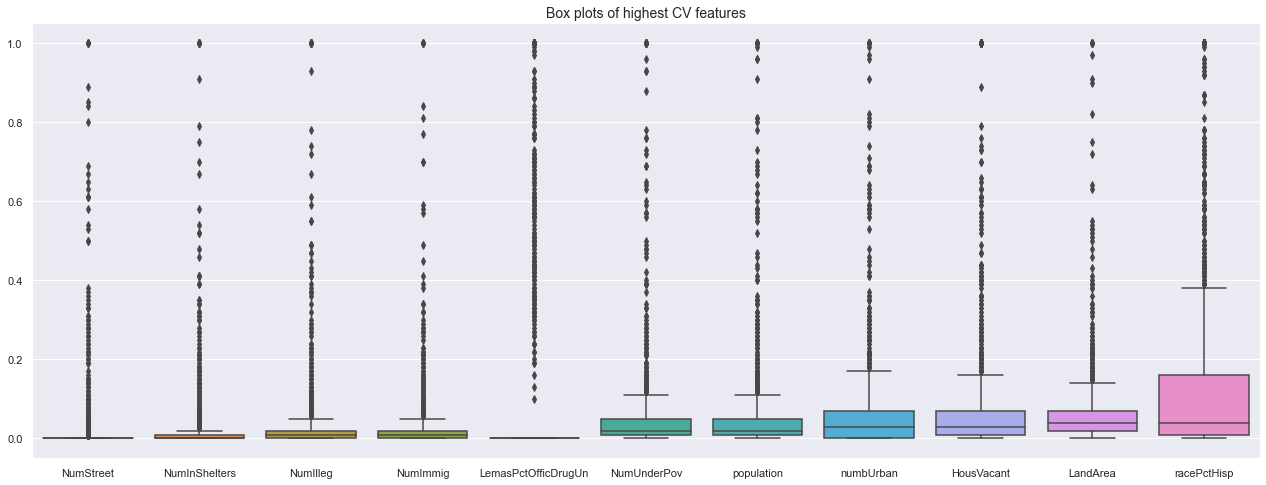

In [269]:
sns.set(rc = {'figure.figsize':(22,8)})
boxplot = sns.boxplot(data=df_best_ftrs)
boxplot.set_title("Box plots of highest CV features", fontsize=14)
plt.show()

## Conclusions
We can see that population and numbUrban have linear correlation and the rest have trivial correlation with one another. 



### 2f - Linear Model with Least Squares


In [270]:
train_data_X = train_data.drop(['ViolentCrimesPerPop'], axis=1)
train_data_Y = train_data['ViolentCrimesPerPop']
reg = LinearRegression().fit(train_data_X, train_data_Y)

In [271]:
test_data_X = test_data.drop(['ViolentCrimesPerPop'], axis=1)
test_data_Y = test_data['ViolentCrimesPerPop']
test_Y_pred = reg.predict(test_data_X)
test_error = np.sum(np.square(test_data_Y - test_Y_pred))

In [272]:
print(f'Test Error: {test_error}')

Test Error: ViolentCrimesPerPop    9.052844
dtype: float64


### 2g - Ridge Regression Model

In [276]:
alphas = [x for x in range(1, 50)]

regressor = RidgeCV(alphas=alphas, cv=5)

regressor.fit(train_data_X, train_data_Y)


RidgeCV(alphas=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
        cv=5)

In [277]:
test_Y_pred = regressor.predict(test_data_X)
test_error = np.sum(np.square(test_data_Y - test_Y_pred))
print(f'Test Error: {test_error}')
print(f'Alpha: {regressor.alpha_}')

Test Error: ViolentCrimesPerPop    8.793107
dtype: float64
Alpha: 2


### 2h - Lasso Model

In [365]:
regressor = LassoCV(alphas=None, cv=5, max_iter=2000)

regressor.fit(train_data_X, train_data_Y)


test_Y_pred = regressor.predict(test_data_X).reshape(499, 1)


test_error = np.sum(np.square(test_data_Y - test_Y_pred))





ftrs = []

for i in range(len(regressor.coef_)):
    if(float(regressor.coef_[i]) != 0):
        ftrs.append(train_data_X.columns[i])

In [367]:
unst_ftrs = len(ftrs)
unst_test_error = test_error

print(f'Features selected by nonstandardized model: {ftrs}')
print(f'# of Features selected by nonstandardized model: {unst_ftrs}')
print(f'Test Error: {unst_test_error}')

Features selected by nonstandardized model: [('racepctblack',), ('racePctAsian',), ('agePct12t21',), ('agePct12t29',), ('pctUrban',), ('pctWWage',), ('pctWFarmSelf',), ('pctWInvInc',), ('pctWSocSec',), ('pctWPubAsst',), ('pctWRetire',), ('whitePerCap',), ('blackPerCap',), ('indianPerCap',), ('AsianPerCap',), ('OtherPerCap',), ('HispPerCap',), ('PctPopUnderPov',), ('PctLess9thGrade',), ('PctEmploy',), ('PctEmplManu',), ('PctOccupManu',), ('MalePctDivorce',), ('MalePctNevMarr',), ('FemalePctDiv',), ('PctKids2Par',), ('PctYoungKids2Par',), ('PctTeen2Par',), ('PctWorkMom',), ('NumIlleg',), ('PctIlleg',), ('NumImmig',), ('PctImmigRec10',), ('PctRecImmig10',), ('PctNotSpeakEnglWell',), ('PctLargHouseOccup',), ('PersPerOccupHous',), ('PctPersOwnOccup',), ('PctPersDenseHous',), ('PctHousLess3BR',), ('MedNumBR',), ('HousVacant',), ('PctHousOccup',), ('PctVacantBoarded',), ('PctVacMore6Mos',), ('MedYrHousBuilt',), ('PctHousNoPhone',), ('PctWOFullPlumb',), ('OwnOccLowQuart',), ('RentLowQ',), ('Me

### Standardize Features

In [303]:
model = LassoCV(alphas=None, cv=5, max_iter=2000)
pipeline = Pipeline([
                     ('scaler', StandardScaler()),
                     ('model', model)
])



In [304]:
pipeline.fit(train_data_X, train_data_Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LassoCV(cv=5, max_iter=2000))])

In [310]:
print(test_data_Y)

    ViolentCrimesPerPop
0                  0.12
1                  0.11
2                  0.12
3                  0.06
4                  0.12
..                  ...
494                0.09
495                0.45
496                0.23
497                0.19
498                0.48

[499 rows x 1 columns]


In [371]:
test_Y_pred = pipeline.predict(test_data_X).reshape(499, 1)
test_error = np.sum(np.square(test_data_Y - test_Y_pred))

ftrs = []

for i in range(len(model.coef_)):
    if(float(model.coef_[i]) != 0):
        ftrs.append(train_data_X.columns[i])

In [373]:
unst_ftrs = len(ftrs)
unst_test_error = test_error

print(f'Features selected by standardized model: {ftrs}')
print(f'# of Features selected by standardized model: {unst_ftrs}')
print(f'Test Error: {unst_test_error}')

Features selected by standardized model: [('racepctblack',), ('racePctAsian',), ('agePct12t21',), ('agePct12t29',), ('pctUrban',), ('pctWWage',), ('pctWFarmSelf',), ('pctWInvInc',), ('pctWSocSec',), ('pctWPubAsst',), ('pctWRetire',), ('whitePerCap',), ('blackPerCap',), ('indianPerCap',), ('AsianPerCap',), ('OtherPerCap',), ('HispPerCap',), ('PctPopUnderPov',), ('PctLess9thGrade',), ('PctEmploy',), ('PctEmplManu',), ('MalePctDivorce',), ('MalePctNevMarr',), ('FemalePctDiv',), ('PctKids2Par',), ('PctYoungKids2Par',), ('PctTeen2Par',), ('PctWorkMom',), ('NumIlleg',), ('PctIlleg',), ('NumImmig',), ('PctImmigRec5',), ('PctImmigRec10',), ('PctRecImmig10',), ('PctNotSpeakEnglWell',), ('PctLargHouseOccup',), ('PersPerOccupHous',), ('PctPersOwnOccup',), ('PctPersDenseHous',), ('PctHousLess3BR',), ('HousVacant',), ('PctHousOccup',), ('PctVacantBoarded',), ('PctVacMore6Mos',), ('MedYrHousBuilt',), ('PctHousNoPhone',), ('PctWOFullPlumb',), ('RentLowQ',), ('MedRent',), ('MedRentPctHousInc',), ('Med

Standardizing the features gives us about the same test error but less features selected

### PCA MODEL

In [348]:
pca = PCA()
X_reduced = pca.fit_transform(scale(train_data_X))
X_reduced_test = pca.fit_transform(scale(test_data_X))


cv = RepeatedKFold(n_splits=5, random_state=1, n_repeats=3)

In [319]:
n = len(X_reduced)
regr = LinearRegression()
mse = []
test_errors = []

best_m = 122
least_mse = 1000


regr.fit(np.ones((n,1)), train_data_Y)
score = -1*cross_val_score(regr, np.ones((n,1)), train_data_Y.values.ravel(), cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)  
test_Y_pred = regr.predict(np.ones((len(X_reduced_test),1)))
test_error = mean_squared_error(test_data_Y,test_Y_pred)
test_errors.append(test_error)
    

for i in range(1, len(X_reduced[0])+1):
    regr.fit(X_reduced[:,:i], train_data_Y)
    score = -1*cross_val_score(regr, X_reduced[:,:i], train_data_Y.values.ravel(), cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    if(mse[-1] < least_mse):
        best_m = i
        least_mse = mse[-1]
    test_Y_pred = regr.predict(X_reduced_test[:,:i])
    test_error = mean_squared_error(test_data_Y,test_Y_pred)
    test_errors.append(test_error)

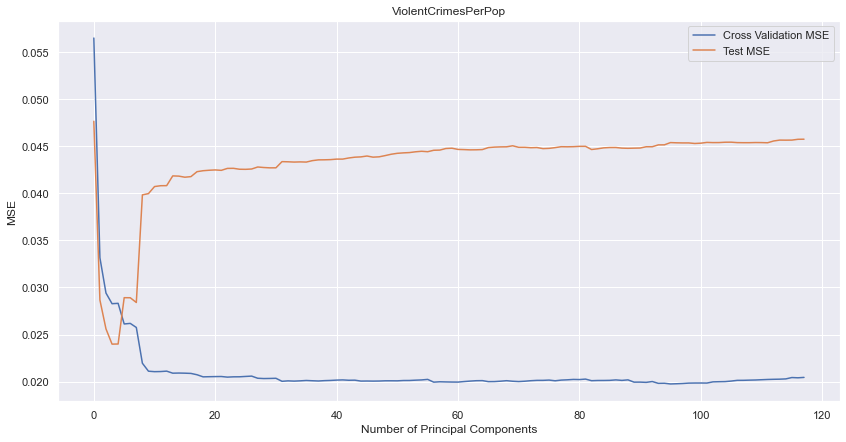

In [320]:

sns.set()

plt.figure(figsize=(14,7))
sns.lineplot(y=mse[:-5], x=[x for x in range(0, len(X_reduced[0])+1)][:-5], label="Cross Validation MSE")
sns.lineplot(y=test_errors[:-5], x=[x for x in range(0, len(X_reduced[0])+1)][:-5], label="Test MSE")
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('ViolentCrimesPerPop')
plt.show()

In [322]:
X_reduced_train = pca.fit_transform(scale(train_data_X))

regr.fit(X_reduced_train[:,:best_m], train_data_Y)

X_reduced_test = pca.fit_transform(scale(test_data_X))

test_Y_pred = regr.predict(X_reduced_test[:,:best_m])

test_error = np.sum(np.square(test_data_Y - test_Y_pred))


In [326]:
analysis = {
                'Optimal M': best_m,
                'Test Error (RSS)': test_error
               }

summary_df = pd.DataFrame(analysis)
print('PCR predictions')
print(summary_df)

PCR predictions
                     Optimal M  Test Error (RSS)
ViolentCrimesPerPop         95         22.653923


### j - Boosting Tree - XGBOOST

In [338]:
daya_dmatrix = xgb.DMatrix(data=train_data_X,label=train_data_Y)

In [340]:
cv = RepeatedKFold(n_splits=5, random_state=1, n_repeats=3)

mse = []
test_errors = []

best_alpha = 0
least_mse = 1000


for alpha in range(1, 1001):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = alpha, n_estimators = 10)
    xg_reg.fit(train_data_X,train_data_Y)
    score = -1*cross_val_score(xg_reg, train_data_X, train_data_Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1).mean()
    mse.append(score)
    if(mse[-1] < least_mse):
        best_alpha = alpha
        least_mse = mse[-1]
    test_Y_pred = xg_reg.predict(test_data_X)
    test_error = mean_squared_error(test_data_Y, test_Y_pred)
    test_errors.append(test_error)

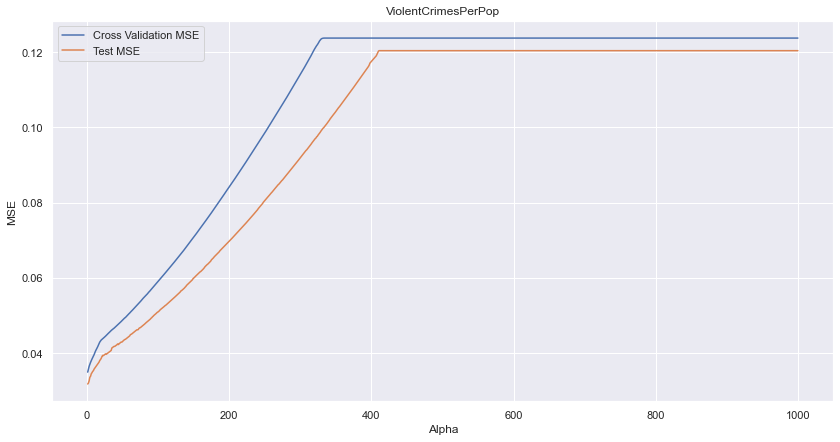

In [341]:
alphas = [x for x in range(1,1001)]

sns.set()

plt.figure(figsize=(14,7))
sns.lineplot(y=mse, x=alphas, label="Cross Validation MSE")
sns.lineplot(y=test_errors, x=alphas, label="Test MSE")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('ViolentCrimesPerPop')
plt.show()

In [343]:
print(f'Best a: {best_alpha} best MSE: {test_error}')

Best a: 1 best MSE: 0.12040120240480963
